# **Pretrained Classification using MMoCHi**

**Author:** Daniel Caron

**In this notebook, we walk through applying a pretrained MMoCHi classifier to an unannotated dataset. This is especially useful for evaluating performance on completely held-out data. First, we will load in a new dataset and perform similar preprocessing and landmark registration. Then, we will load in a pretrained MMoCHi classifier, then apply it to predict cell type identities in this new dataset.** 


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A note before we begin: While it is technically possible to apply pretrained MMoCHi classifiers to new datasets or batches without retraining, a MMoCHi classifier is ideally trained (or retrained) using the entire dataset. This helps to maximize its performance classifying rare cell types. Moreover, new datasets may contain unique biological conditions, sequencing chemistries, or alignment and preprocessing steps, which may affect information transfer. If you do need to apply a pretrained MMoCHi classifier to new data, try to ensure the training dataset was as representative as possible of the new dataset.    

## **Import packages**

In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'

import mmochi as mmc
import os

In [2]:
#global defaults
mmc.DATA_KEY = 'landmark_protein'
mmc.BATCH_KEY = 'batch'

## **Downloading and preprocessing the data**

<div class="alert alert-danger">
    
**Run Integrated Classification First!**
    
This tutorial builds off of the [Integrated Classification tutorial](./Integrated_Classification.ipynb), and uses the MMoCHi classifier trained and saved during that tutorial.
</div>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; We have previously classified two datasets from 10X Genomics. Here, we will apply that pretrained classifier to another 10X dataset (pbmc_1k_protein_v3). We will first apply the same preprocessing and normalization applied to the training dataset: 

In [3]:
batch_name = 'pbmc_1k_protein_v3'
file = 'data/pbmc_1k_protein_v3.h5'
url = 'http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5'

adatas = mmc.utils.preprocess_adatas(file, backup_urls = url, log_CP_ADT=1e3, log_CP_GEX=1e4)
held_out_batch = adatas[0]
held_out_batch.obs['batch'] = batch_name

## **Normalizing ADTs - Landmark Registration**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Similar to our other batches, this CITE-Seq data will require careful integration. Because we fixed our peak alignment previously to specific arbitrary values (1 and 3), we can easily reproduce the same integration with this new batch without needing to load in the other dataset. 

In [4]:
held_out_batch = mmc.landmark_register_adts(held_out_batch, single_peaks=['CD25'])

Running with batch batch


  0%|          | 0/1 [00:00<?, ?it/s]

Although we will skip this step here, one should carefully evaluate landmark registration across all new batches and ADTs to ensure landmarks were properly detected. For more details, see the [Landmark Registration tutorial](Landmark_Registration.ipynb).

## **Exploring the data**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Prior to any form of cell type classification, it's important to get familiar with your dataset! Here, we're going to focus on identifying whether there are any novel cell types that were not included when training our previous classifier. These novel cell types would need to be annotated by clustering and removed prior to classification.

Since these processes are stochastic, we have provided the UMAP coordinates and Leiden clusters as .csv files to load in:

In [5]:
if os.path.isfile('data/Integrated_Classification_X_umap.txt') and os.path.isfile('data/Integrated_Classification_leiden.csv'):
    held_out_batch.obsm['X_umap'] = np.loadtxt('data/Holdout_X_umap.txt')
    held_out_batch.obs['leiden'] = pd.read_csv('data/Holdout_leiden.csv').set_index('Unnamed: 0')['leiden'].astype(str)
else:
    print('No pre made files found, generating new leiden clusers')
    sc.pp.highly_variable_genes(held_out_batch)
    sc.pp.pca(held_out_batch)
    sc.pp.neighbors(held_out_batch)
    sc.tl.umap(held_out_batch)
    sc.tl.leiden(held_out_batch)
    np.savetxt('data/Holdout_X_umap.txt',held_out_batch.obsm['X_umap'])
    held_out_batch.obs['leiden'].to_csv('data/Holdout_leiden.csv')

<div class="alert alert-info">
    
**Unsupervised analysis tip — Multimodal**
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here, for simplicity, we are only performing UMAP analysis and clustering on the gene expression (GEX). As brefore, you should repeat this with ADT data, or using multimodal techniques, such as [totalVI](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/totalVI.html).
</div>

Let's first plot the batches and Leiden clusters to evaluate clustering:

... storing 'batch' as categorical
... storing 'leiden' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


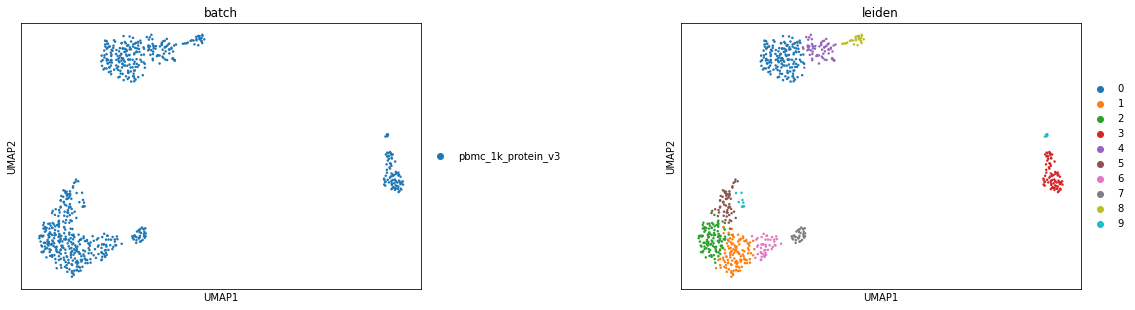

In [6]:
sc.pl.umap(held_out_batch, color=['batch','leiden'], s=25, sort_order=False, wspace =.5)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's take a look at some marker genes and proteins for various immune cell subsets. Performing this cursory unsupervised analysis is critical, as it will help you identify any quality control issues, unexpected cell types, or novel cell states. This can also be a helpful step to validate that the markers you plan to use for cell type identification are well-expressed in the data set.

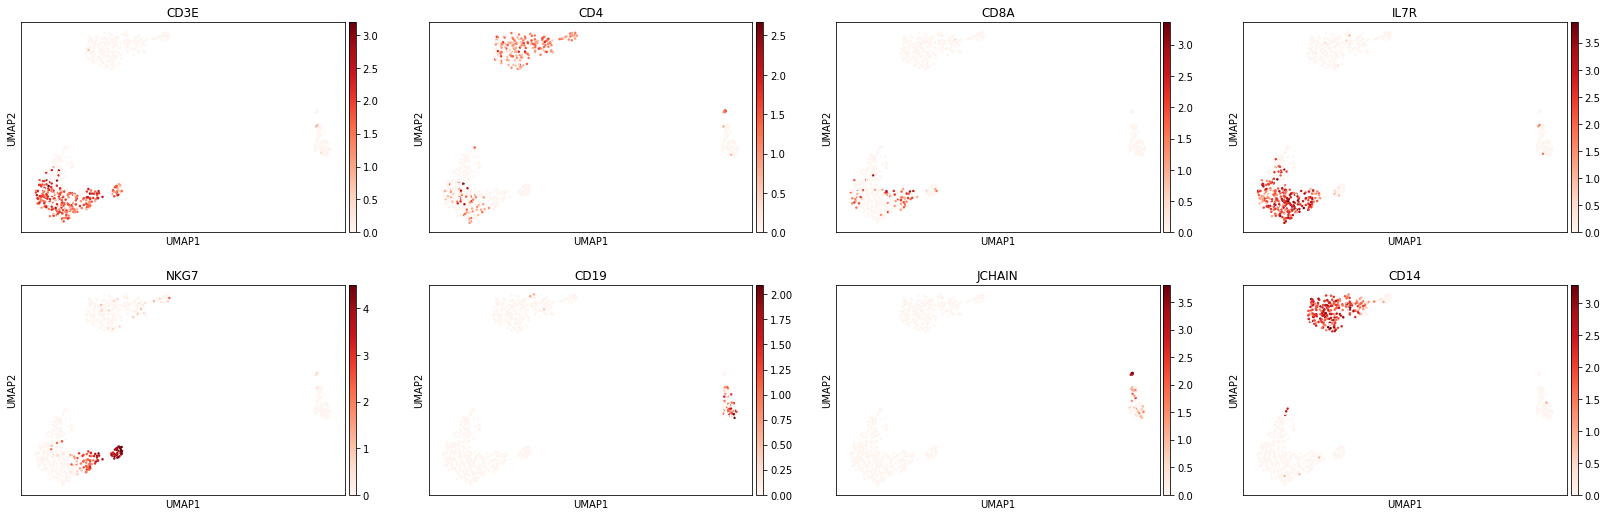

In [7]:
sc.pl.umap(held_out_batch, color=['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14'],
           s=25, sort_order=False, cmap='Reds')

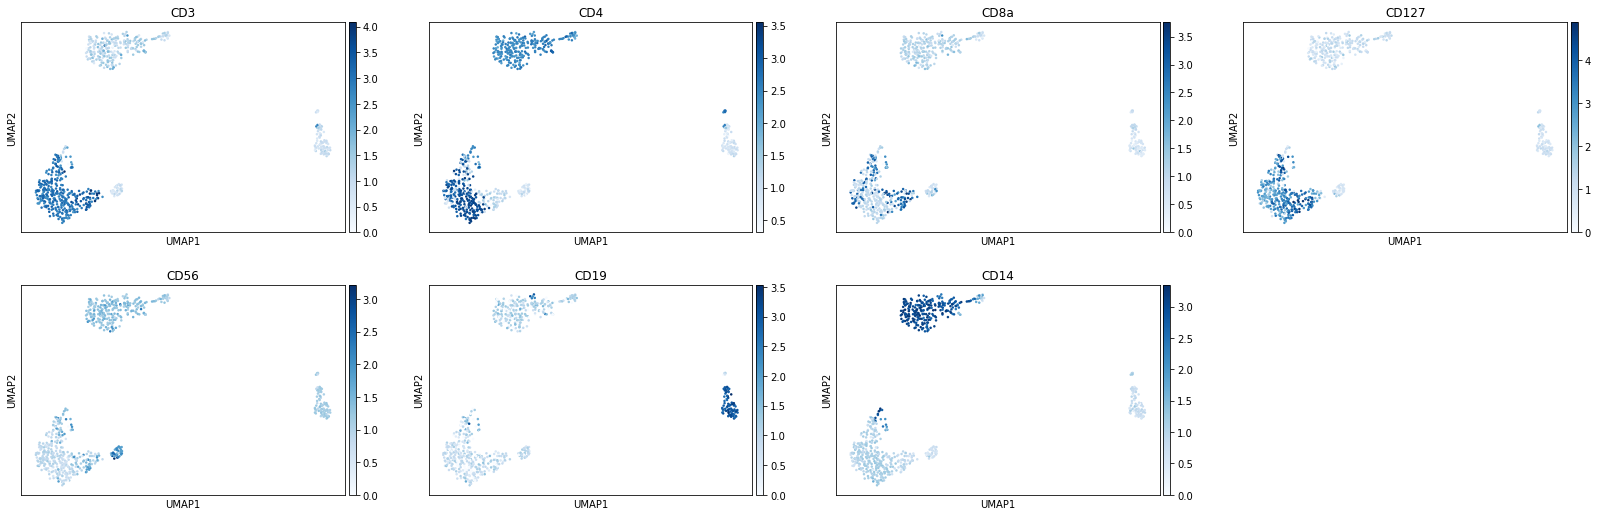

In [8]:
protein_adata = anndata.AnnData(held_out_batch.obsm['landmark_protein'], held_out_batch.obs.copy(), dtype=float)
protein_adata.obsm['X_umap'] = held_out_batch.obsm['X_umap'].copy()
sc.pl.umap(protein_adata, color=['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'],
           s=25, sort_order=False, cmap='Blues')

There do not appear to be any clusters here corresponding to unexpected cell types. We can proceed with classification.

In [9]:
held_out_batch.obs['T_B doublets'] = 'False'

## **Load and apply pretrained MMoCHi classifier**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Note: Running the classifier on another donor requires the features line up exactly. This generally means the feature matrices must be created using the same or very similar alignment conditions and preprocessing. This is all true for our held-out dataset. Let's load in the hierarchy we saved earlier:


In [10]:
if os.path.isfile('data/IntegratedClassifier.hierarchy'):
    hierarchy = mmc.Hierarchy(load='data/IntegratedClassifier')
else:
    print('No file found, run integrated clasification tutorial to generate this trained hierarchy')

Loading classifier from data/IntegratedClassifier...


Loaded data/IntegratedClassifier.hierarchy


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Predicting on the new data is as simple as running the classify function with the pretrained hierarchy using `retrain=False`. We can then collect the terminal names in the `.obs` for our final classification. Note that this runs much quicker than training on a large dataset.

In [11]:
held_out_batch,_ = mmc.classify(held_out_batch, hierarchy, 'lin', retrain=False)
held_out_batch = mmc.terminal_names(held_out_batch)

Setting up...
Using .X and landmark_protein


No min_cells feature reduction...
Resorting to enforce sorted order of features by name


Set up complete.
Using 33555 features


Running with batch batch
Using weights of: [1.0] for random forest n_estimators


Data subsetted on All in All
Running high-confidence populations for Removal...


Running high-confidence thresholds in pbmc_1k_protein_v3


Performing cutoff for Removal...
Merging data into adata.obsm['lin']
Predicted:
Removal_class
To classify    713
Name: count, dtype: int64
Data subsetted on To classify in Removal
Predicting for Broad Lineages...


Limiting features using listlike, make sure you include modality information...


Merging data into adata.obsm['lin']
Predicted:
Broad Lineages_class
Lymphocyte    445
Myelocyte     268
Name: count, dtype: int64


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.1s finished


Data subsetted on Lymphocyte in Broad Lineages
Predicting for Lymphoid...


Limiting features using listlike, make sure you include modality information...


Merging data into adata.obsm['lin']
Predicted:
Lymphoid_class
T cell    335
B cell     80
NK_ILC     30
Name: count, dtype: int64
Data subsetted on NK_ILC in Lymphoid
Predicting for NK_ILC Subsets...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished
Limiting features using listlike, make sure you include modality information...


Merging data into adata.obsm['lin']
Predicted:
NK_ILC Subsets_class
NK     22
ILC     8
Name: count, dtype: int64


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.1s finished


Data subsetted on T cell in Lymphoid
Predicting for CD4_CD8...


Limiting features using listlike, make sure you include modality information...


Merging data into adata.obsm['lin']
Predicted:
CD4_CD8_class
CD4 T cell    274
CD8 T cell     61
Name: count, dtype: int64


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.1s finished
Converting columns in adata.obsm["lin"] to savable dtypes...


Lastly, to verify the classifier performed well, we can evaluate expression of known marker genes and proteins for these populations. First, let's look at it on a UMAP

... storing 'T_B doublets' as categorical


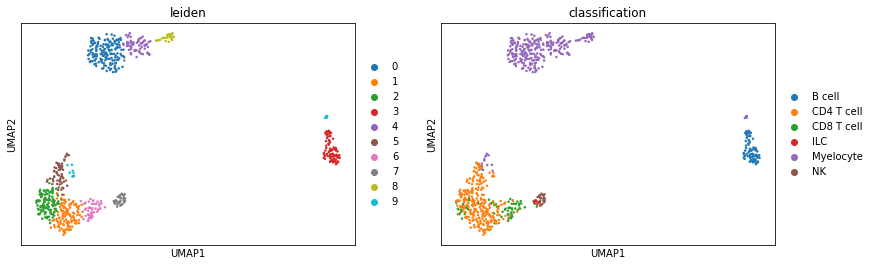

In [12]:
sc.pl.umap(held_out_batch, color=['leiden','classification'], ncols=5, s=25, sort_order=False)

We can also look at marker expression using dotplots for GEX and violin plots for ADTs:

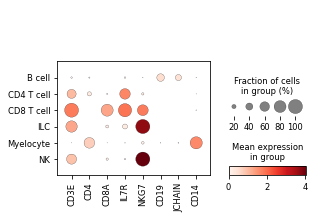

/home/ubuntu/miniconda3/envs/mmochi0.3.0/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:462: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/home/ubuntu/miniconda3/envs/mmochi0.3.0/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:462: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/home/ubuntu/miniconda3/envs/mmochi0.3.0/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:462: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/home/ubuntu/miniconda3/envs/mmochi0.3.0/lib/python3.8/site-packages/scanpy/plotting/_sta

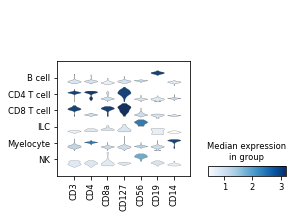

In [13]:
protein_adata.obs['classification'] = held_out_batch.obs.classification
sc.pl.dotplot(held_out_batch, ['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14'], 'classification')
sc.pl.stacked_violin(protein_adata, ['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'], 'classification')

<div class="alert alert-success">
    
**Great!**
    
MMoCHi appears to have performed well annotating this dataset!
</div>